In [93]:
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
from PyRadioLoc.Utils.GeoUtils import GeoUtils
%run UtilsLightGBMFingerPrinting.ipynb

In [94]:
FILES = [
    
    './FinalResult/Resultados_Metodo_7.csv',  # CDB gerado com LightGBM dados Outdoor
    './FinalResult/Resultados_Metodo_8.csv',  # CDB gerado com LightGBM dados Indoor
    './FinalResult/Resultados_Metodo_9.csv',  # CDB gerado com LightGBM dados Indoor-Outdoor
    
    './FinalResult/Resultados_Metodo_10.csv',  # CDB gerado com SVR dados Outdoor
    './FinalResult/Resultados_Metodo_11.csv',  # CDB gerado com SVR dados Indoor
    './FinalResult/Resultados_Metodo_12.csv',  # CDB gerado com SVR dados Indoor-Outdoor
    
]
METHODS = [x.split("_")[-1].split(".")[0] for x in FILES]     # lista contendo os metodos que serão usados
db = pd.read_csv('databases/meds_pandas.csv')
erbs = pd.read_csv('databases/Bts.csv')
#errorLocation = pd.read_csv('result/erros.csv')
ERROS_CSV_FILE = './result/erros.csv' 

# 1. Análise dos Dados:

In [95]:
data = pd.read_csv("./databases/meds_pandas.csv")
data = data.drop("idx", axis = 1)
data = data.drop("indoor", axis = 1)
round(data.describe(), 4)

,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,lat,...,ang_3,cos_3,sin_3,tg_3,delay_1,delay_2,delay_3,delay_12,delay_13,delay_23
count,9679.0000,9679.0000,9679.0000,9679.0000,9679.0000,9679.0000,9679.0000,9679.0000,9679.0000,9679.0000,...,9679.0000,9679.0000,9679.0000,9679.0000,9679.0000,9679.0000,9679.0000,9679.0000,9679.0000,9679.0000
mean,-100.8505,-105.7477,-100.5873,-103.4908,-97.2664,-97.2438,-93.6884,-93.3174,-107.5162,-8.0545,...,80.3135,0.0929,0.8970,70.6708,5.5572,3.6169,3.1494,1.9403,2.4078,0.4675
std,9.9980,10.4036,9.9710,13.5565,8.9615,10.0726,7.6479,8.1451,10.9900,0.0024,...,31.2931,0.3136,0.2975,5598.7125,1.0481,1.0525,1.0013,1.4936,1.7919,1.8361
min,-115.0000,-115.0000,-115.0000,-115.0000,-115.0000,-115.0000,-113.3000,-115.6300,-115.0000,-8.0596,...,-178.3209,-0.9996,-1.0000,-769.9706,1.0000,1.0000,0.0000,-4.0000,-4.0000,-5.0000
25%,-107.6500,-115.0000,-107.1486,-115.0000,-102.5800,-101.7014,-99.4800,-99.0050,-115.0000,-8.0558,...,88.7705,-0.0729,0.9771,-33.2684,6.0000,3.0000,3.0000,2.0000,3.0000,0.0000
50%,-103.0400,-110.4250,-99.7500,-108.4300,-97.2000,-95.6157,-94.9433,-95.6300,-115.0000,-8.0555,...,91.7217,-0.0300,0.9973,-13.6790,6.0000,4.0000,3.0000,2.0000,3.0000,0.0000
75%,-93.5429,-97.3500,-93.4346,-96.7033,-92.0800,-92.0136,-89.4450,-89.3740,-97.6000,-8.0553,...,94.1812,-0.0043,0.9996,-0.8376,6.0000,4.0000,3.0000,3.0000,3.0000,1.0000
max,-61.3800,-64.8200,-60.6400,-36.9600,-55.5500,-56.9800,-52.6900,-55.8700,-50.1000,-8.0464,...,175.1856,1.0000,1.0000,486759.9534,8.0000,7.0000,7.0000,5.0000,7.0000,7.0000


# 2. Erros de localização médio, mínimo, máximo e desvio padrão

In [96]:
def calculate_errors(df_real, df_predict):
    """
    Retorna uma lista contendo os erros em metros de todos os pontos no real e na predição
    """
    df_merged = merge_on_pontoId(df_predict, df_real)
    errors = []
    
    for idx, point in df_merged.iterrows():
        distance = GeoUtils.distanceInKm(point.lat, point.lon, point.lat_pred, point.lon_pred)
        errors.append(round(distance * 1000, 2))
        
    return errors

def calculate_theorical_errors():
    df_real = pd.read_csv("./databases/meds_pandas.csv")
    dict_errors = {}
    
    for file, method in zip(FILES,METHODS):
        df_predict = pd.read_csv(file)
        dict_errors[method] = calculate_errors(df_real, df_predict)
    
    return pd.DataFrame(dict_errors)

In [97]:
# Gera o dataframe contendo os erros
errors_df = calculate_theorical_errors()
round(errors_df.describe(), 2)

,7,8,9,10,11,12
count,400.00,400.00,400.00,400.00,400.00,400.00
mean,43.91,60.65,49.08,48.76,90.08,70.52
std,39.74,24.64,31.32,43.44,24.59,40.82
min,0.90,21.40,1.17,0.66,32.13,1.51
25%,15.26,46.97,23.26,15.70,72.88,34.66
50%,32.74,59.28,48.14,35.86,87.04,75.63
75%,56.86,71.71,71.28,66.50,102.64,102.64
max,217.92,116.27,193.10,257.88,137.37,191.02


In [71]:
errors_df.to_csv(ERROS_CSV_FILE, index=False)

# 3. Histograma dos erros (em metros)

In [81]:
#greek_letterz=[chr(code) for code in range(945,970)]
#print(greek_letterz)

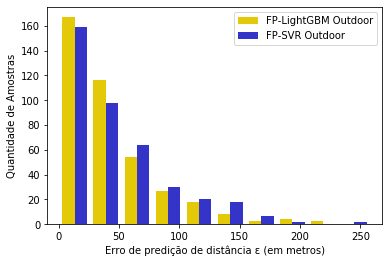

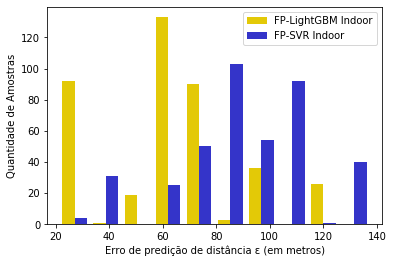

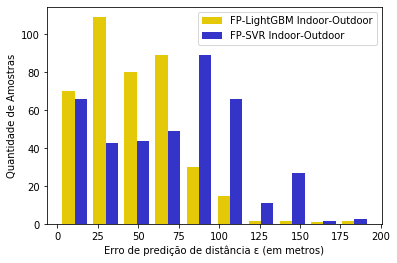

In [92]:
for i in range(0,3):
    environment = ['Outdoor', 'Indoor', 'Indoor-Outdoor']
    errorLocation = pd.read_csv(ERROS_CSV_FILE)
    score_FP_LightGBM = errorLocation[str(i + 7)]
    score_FP_SVR = errorLocation[str(i + 10)]
    legend = ['FP-LightGBM '+ environment[i], 'FP-SVR '+ environment[i]]
    plt.hist([score_FP_LightGBM, score_FP_SVR], color=['#e3c907', '#3434c9'])
    plt.xlabel("Erro de predição de distância "+chr(949)+" (em metros)")
    plt.ylabel("Quantidade de Amostras")
    plt.legend(legend)
    #plt.xticks(np.arange(0, 300, 50))#Metros
    #plt.yticks(np.arange(0, 180, 30))# Amostras
    plt.savefig('./result/'+ environment[i]+'.png')  
    plt.show()

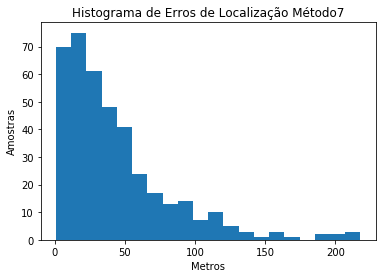

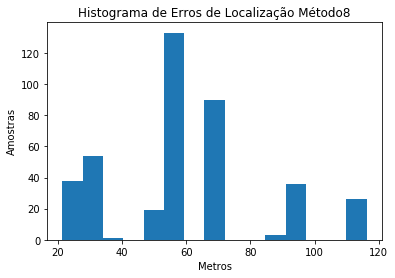

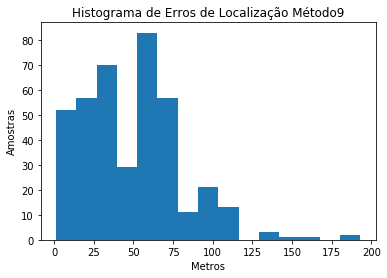

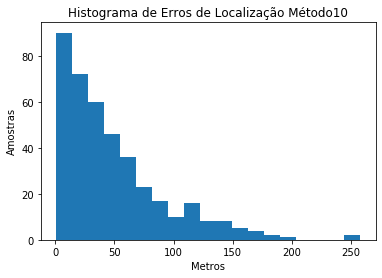

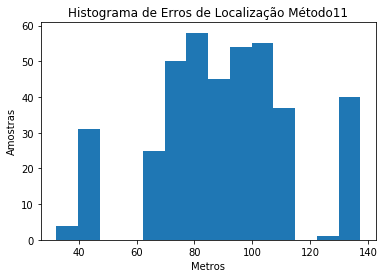

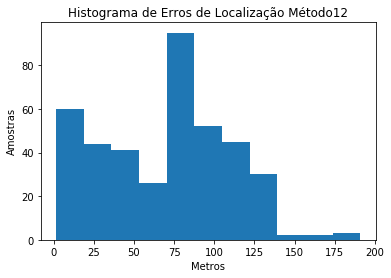

In [76]:
for i in METHODS:
    errorLocation = pd.read_csv(ERROS_CSV_FILE)
    plt.title("Histograma de Erros de Localização Método" + str(i))
    histogram_example = plt.hist(errorLocation[str(i)], bins='auto')
    plt.xlabel('Metros')
    plt.ylabel('Amostras')
    plt.show()

# 4. Boxplot dos erros (em metros)

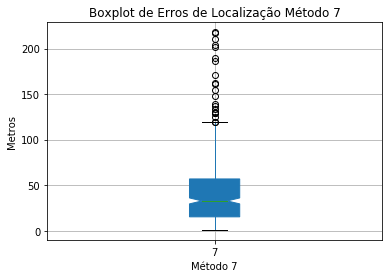

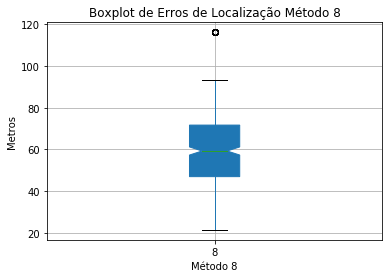

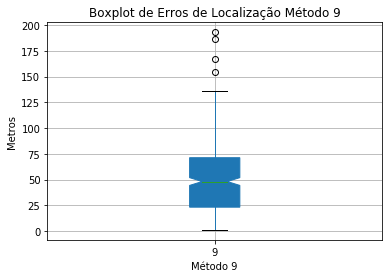

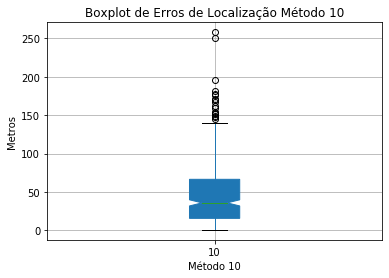

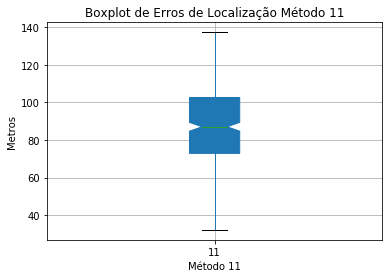

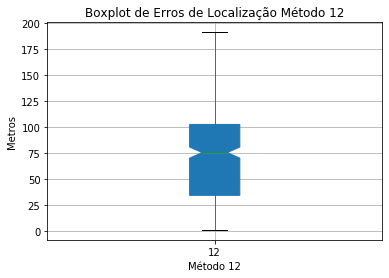

In [8]:
for i in METHODS:
    boxplotErrorLocationM1 = errorLocation.boxplot(column=[str(i)], notch = True, patch_artist = True)
    plt.title("Boxplot de Erros de Localização Método "+ str(i))
    plt.xlabel('Método '+ str(i))
    plt.ylabel('Metros')
    plt.show()

In [22]:
y_test = pd.read_csv("databasesTCC/Outdoor_y_test_10%.csv")
y_test.count()

rssi_1_1    613
rssi_1_2    613
rssi_1_3    613
rssi_2_1    613
rssi_2_2    613
rssi_2_3    613
rssi_3_1    613
rssi_3_2    613
rssi_3_3    613
dtype: int64

In [23]:
y_test = pd.read_csv("databasesTCC/indoor_X_train_90%.csv")
y_test.count()

idx         5292
lat         5292
lon         5292
dist_1      5292
dist_2      5292
dist_3      5292
ang_1       5292
cos_1       5292
sin_1       5292
tg_1        5292
ang_2       5292
cos_2       5292
sin_2       5292
tg_2        5292
ang_3       5292
cos_3       5292
sin_3       5292
tg_3        5292
delay_1     5292
delay_2     5292
delay_3     5292
delay_12    5292
delay_13    5292
delay_23    5292
dtype: int64

In [24]:
y_test = pd.read_csv("databasesTCC/indoor_X_test_10%.csv")
y_test.count()

idx         1323
lat         1323
lon         1323
dist_1      1323
dist_2      1323
dist_3      1323
ang_1       1323
cos_1       1323
sin_1       1323
tg_1        1323
ang_2       1323
cos_2       1323
sin_2       1323
tg_2        1323
ang_3       1323
cos_3       1323
sin_3       1323
tg_3        1323
delay_1     1323
delay_2     1323
delay_3     1323
delay_12    1323
delay_13    1323
delay_23    1323
dtype: int64